# Molecular Orbital Theory
#### Dalton Glenny, Courtland Priest, Abby Wilson

### Determining Charge Densities and Bond Order by Huckel Theory

Import necessary packages and functions

In [47]:
import numpy as np
import numpy.linalg as linalg
from numpy import matrix
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sparseAlg
import ase
from ase import neighborlist
from ase.utils import natural_cutoffs
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse import identity
from ase.build import molecule
from ase.build import graphene_nanoribbon

In [2]:
# gnr = graphene_nanoribbon(4,3,'zigzag', saturated=False) """To produce a graphene nanoribbon 4 unit cells wide and 3 long"""
c60 = molecule('C60')
numC = 60 #number of carbon atoms in the molecule

cutOff = natural_cutoffs(c60)
neighborList = neighborlist.NeighborList(cutOff, self_interaction=False, bothways=True)
neighborList.update(c60)
T = neighborList.get_connectivity_matrix()

#matrix = csr_matrix.todense(matrix) """Not needed when getSparseHamil is used"""

Converts topological (connectivity) matrix to sparse Hamiltonian matrix without densifying it

In [3]:
def getSparseHamil(a, b, T):
    I = identity(numC)
    H = a*I + b*T
    return H

Convert a dense topological matrix to a Hamiltonian matrix

In [4]:
def getHamil(a, b, T):
    I = np.identity(len(T))
    H = np.zeros((len(T), len(T)))

    for i in range(len(T)):
        for j in range(len(T)):
            H[i][j] = a*I[i][j] + b*T[i][j]

    return H

Get eigenvalues and eigenvectors from a Hamiltonian matrix

In [5]:
#Returns eigen values
def getEnergyLevels(H):
    vals, vecs, = linalg.eig(H)
    return vals

#Returns eigen vectors
def getEignVecs(H):
    vals, vecs, = linalg.eig(H)

    #Use the following only if using getHamil (the non-sparse version)
    #switch the eigen vector matrix so that the rows are vectors
    #vecs_adj = []
    #for i in range(len(vecs)):
    #    orbital = []
    #    for j in range(len(vecs)):
    #        orbital.append(vecs[j][i])
    #    vecs_adj.append(orbital)

    return vecs #or vecs_adj

In [6]:
#Creates a matrix of form [[value, vector]...]
#this pairs the vectors and values so that we can sort the values but keep track of the corresponding vectors
def sortEigen(H):

    vals = getEnergyLevels(H)
    vecs = getEignVecs(H)

    eigenSorted = []
    for i in range(len(vals)):
        eigenSorted.append([vals[i], vecs[i]])

    eigenSorted.sort()
    return eigenSorted

In [49]:
#Returns a sorted list of form [[value, vector],...]
#For sparse hamiltonian
def getEignVecsSp(H, numCarbon):
    vals, vecs, = sparseAlg.eigs(H, k=(numCarbon-2)) #k must be < N-1

    #switch the eigen vector matrix so that the rows are vectors
    vecs_adj = []
    for i in range(len(vecs[0])):
        eigVec = []
        for j in range(len(vecs)):
            eigVec.append(vecs[j][i].real)

        vecs_adj.append(eigVec)

    eigSorted = []
    for i in range(len(vals)):
        eigSorted.append([vals[i].real, vecs_adj[i]])

    eigSorted.sort()
    return eigSorted

Graph the eigenvectors

In [8]:
def pltEigen(eigenSorted, molecule_name): #takes in a list of the form returned by sortEigen()
    x = [i for i in range(len(eigenSorted))]

    values = [eigenSorted[i][0] for i in range(len(eigenSorted))]
    vectors = [eigenSorted[i][1] for i in range(len(eigenSorted))]

    for i in range(len(values)):
            values[i] = round(values[i], 3) #round energy values

    n = int(len(values)/2)
    if (len(values) % 2 != 0):
        n += 1

    fig, ax = plt.subplots(nrows=n, ncols=2)
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            if (i+2*j < len(values)):
                print(x, vectors[i+2*j])
                col.scatter(x, vectors[i+2*j], label="E={}".format(values[i+2*j]))
                col.legend(loc="right")

    fig.suptitle("Eigenvectors of {}".format(molecule_name))
    plt.show

Find number of nodes in eigenvector

In [9]:
def getNodes(vec):
    nodes = 0
    pos = vec[0] > 0
    for i in (1, len(vec)):
        if ((vec[i] > 0) != pos):
            nodes +=1
            pos = !pos

    return nodes

Create an energy level diagram. Returns a list in the format [[energy level, occupied?. occupied?], [energy,...]...] where an occupied state is represented by a 1 and an unocupied state is represented by a zero

In [10]:
def energyLevelDiagram(enLevels, numCarbon):
    diagram = np.zeros((len(enLevels), 3))
    for i in range(len(enLevels)):
        diagram[i][0] = enLevels[i][0]

    for i in range(numCarbon):
        if (i%2 == 0):
            diagram[int(i/2)][1] = 1
        else:
            diagram[int(i/2)][2] = 1

    return diagram

Calculate the energy of a bond in Ethelene to be used to calculate the delocalization energy

In [11]:
eth=[[0,1],
 [1,0]]

eth_H = getHamil(-1,-1,eth)

eth_values=getEnergyLevels(eth_H)
print(eth_values)
eth_energy = eth_values[1]

[ 0. -2.]


Calculate the delocalization energy

In [12]:
def delocEnergy(enLevelDiag):

    sum = 0
    numOrbitals = 0
    for j in range(len(enLevelDiag)):
        occupancy = enLevelDiag[j][1] + enLevelDiag[j][2]
        sum += enLevelDiag[j][0] * occupancy
        if (occupancy > 0):
            numOrbitals += 1

    dEnergy = sum - eth_energy*2*numOrbitals # compare to Eth molecule with numOrbital # of bonds with occupation of 2
    return dEnergy

In [13]:
# Calculates the charge density
def chargeDensity(enLevelDiagram, eigenSorted):

    chargeDensity = np.zeros(len(eigenSorted))
    for i in range(len(chargeDensity)): #for each atom
        for j, orbital in enumerate(eigenSorted):
            occupancy = enLevelDiagram[j][1] + enLevelDiagram[j][2] #calculate occupancy of this orbital
            chargeDensity[i] += occupancy * orbital[1][i]**2

    return chargeDensity

In [14]:
#enLevelDiagram: enegy level diagram
#eigenSorted: sorted list of eigen values and vectors
#bonds: list of bonds
def bondOrder(enLevelDiagram, eigenSorted, bonds):

    bondO = np.ones(len(bonds))
    for i, bond in enumerate(bonds):

        for j, orbital in enumerate(eigenSorted):
            occupancy = enLevelDiagram[j][1] + enLevelDiagram[j][2]
            bondO[i] += occupancy * orbital[1][bond[0]] * orbital[1][bond[1]]

    return bondO


### Butadiene

In [15]:
buta = [[0,1,0,0],
       [1,0,1,0],
       [0,1,0,1],
       [0,0,1,0]]

buta_H = getHamil(-1, -1, buta)
print(buta_H)

values = getEnergyLevels(buta_H)
vectors = getEignVecs(buta_H)
butaEigen = sortEigen(buta_H)

print("\nEigenvalues: ", values)
print("\nEigenvectors: ", vectors)
print("\n", butaEigen)

[[-1. -1.  0.  0.]
 [-1. -1. -1.  0.]
 [ 0. -1. -1. -1.]
 [ 0.  0. -1. -1.]]

Eigenvalues:  [-2.61803399 -1.61803399  0.61803399 -0.38196601]

Eigenvectors:  [[ 0.37174803 -0.60150096 -0.37174803  0.60150096]
 [ 0.60150096 -0.37174803  0.60150096 -0.37174803]
 [ 0.60150096  0.37174803 -0.60150096 -0.37174803]
 [ 0.37174803  0.60150096  0.37174803  0.60150096]]

 [[-2.6180339887498922, array([ 0.37174803, -0.60150096, -0.37174803,  0.60150096])], [-1.6180339887498953, array([ 0.60150096, -0.37174803,  0.60150096, -0.37174803])], [-0.3819660112501051, array([0.37174803, 0.60150096, 0.37174803, 0.60150096])], [0.6180339887498943, array([ 0.60150096,  0.37174803, -0.60150096, -0.37174803])]]


[0, 1, 2, 3] [ 0.37174803 -0.60150096 -0.37174803  0.60150096]
[0, 1, 2, 3] [0.37174803 0.60150096 0.37174803 0.60150096]
[0, 1, 2, 3] [ 0.60150096 -0.37174803  0.60150096 -0.37174803]
[0, 1, 2, 3] [ 0.60150096  0.37174803 -0.60150096 -0.37174803]


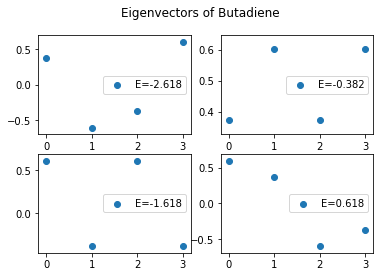

In [16]:
pltEigen(butaEigen, 'Butadiene')

In [17]:
buta_graph = [[0,1],[1,2],[2,3]] #graph of bonds

atoms = {0} #this is a set, so it cant contain duplicate elements
for bond in buta_graph:
    atoms.add(bond[0])
    atoms.add(bond[1])

print("atoms", atoms)
n = len(atoms)

T = np.zeros((n, n))
for bond in buta_graph:
    T[bond[0]][bond[1]] = 1 #this bond exists, so mark it on the Topo
    T[bond[1]][bond[0]] = 1 #this bond exists, so mark it on the Topo

print("Topo \n", T)

atoms {0, 1, 2, 3}
Topo 
 [[0. 1. 0. 0.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]]


In [18]:
diagram = energyLevelDiagram(butaEigen, 4)
print(diagram)

[[-2.61803399  1.          1.        ]
 [-1.61803399  1.          1.        ]
 [-0.38196601  0.          0.        ]
 [ 0.61803399  0.          0.        ]]


In [19]:
dE = delocEnergy(diagram)
print(dE)

-0.47213595499957606


In [20]:
chargeDen = chargeDensity(diagram, butaEigen)
print(chargeDen)

[1. 1. 1. 1.]


In [21]:
bondOrder(diagram, butaEigen, [[0,1],[1,2],[2,3]])

array([0.10557281, 1.        , 0.10557281])

### Benzene

In [22]:
benzT = [[0,1,0,0,0,1],
         [1,0,1,0,0,0],
         [0,1,0,1,0,0],
         [0,0,1,0,1,0],
         [0,0,0,1,0,1],
         [1,0,0,0,1,0]]

benzH = getHamil(-1,-1,benzT)
benzEigen = sortEigen(benzH)

print(*benzEigen, sep="\n")

[-2.9999999999999996, array([-0.40824829, -0.28867513,  0.40824829, -0.28867513, -0.42988269,
       -0.10665483])]
[-2.0, array([ 0.40824829,  0.57735027,  0.40824829, -0.57735027,  0.11882601,
       -0.43806709])]
[-1.9999999999999991, array([-0.40824829, -0.28867513,  0.40824829, -0.28867513,  0.54870871,
        0.54472192])]
[5.551115123125783e-17, array([ 0.40824829, -0.28867513,  0.40824829,  0.28867513,  0.42988269,
       -0.10665483])]
[1.0581813203458523e-16, array([ 0.40824829, -0.28867513,  0.40824829,  0.28867513, -0.54870871,
        0.54472192])]
[0.999999999999999, array([-0.40824829,  0.57735027,  0.40824829,  0.57735027, -0.11882601,
       -0.43806709])]


[0, 1, 2, 3, 4, 5] [-0.40824829 -0.28867513  0.40824829 -0.28867513 -0.42988269 -0.10665483]
[0, 1, 2, 3, 4, 5] [-0.40824829 -0.28867513  0.40824829 -0.28867513  0.54870871  0.54472192]
[0, 1, 2, 3, 4, 5] [ 0.40824829  0.57735027  0.40824829 -0.57735027  0.11882601 -0.43806709]
[0, 1, 2, 3, 4, 5] [ 0.40824829 -0.28867513  0.40824829  0.28867513  0.42988269 -0.10665483]
[0, 1, 2, 3, 4, 5] [-0.40824829 -0.28867513  0.40824829 -0.28867513  0.54870871  0.54472192]
[0, 1, 2, 3, 4, 5] [ 0.40824829 -0.28867513  0.40824829  0.28867513 -0.54870871  0.54472192]


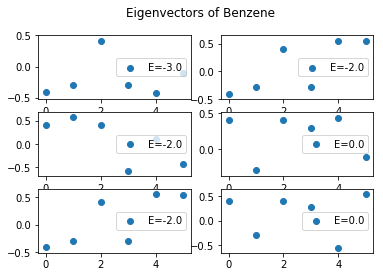

In [23]:
pltEigen(benzEigen, 'Benzene')

In [24]:
benz_diagram = energyLevelDiagram(benzEigen, 6)
print(benz_diagram)

[[-3.00000000e+00  1.00000000e+00  1.00000000e+00]
 [-2.00000000e+00  1.00000000e+00  1.00000000e+00]
 [-2.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 5.55111512e-17  0.00000000e+00  0.00000000e+00]
 [ 1.05818132e-16  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [25]:
benz_dE = delocEnergy(benz_diagram)
print(benz_dE)

-1.9999999999999982


In [26]:
benz_chargeDen = chargeDensity(benz_diagram, benzEigen)
print(benz_chargeDen)

[1. 1. 1. 1. 1. 1.]


In [27]:
bondOrder(benz_diagram, benzEigen, [[0,1],[1,2],[2,3],[3,4],[4,5],[5,0]])

array([1.94280904, 1.        , 0.05719096, 0.79418731, 1.58537792,
       0.28463943])

### Toluene

In [28]:
tolT = [[0,1,0,0,0,1,0],
         [1,0,1,0,0,0,0],
         [0,1,0,1,0,0,0],
         [0,0,1,0,1,0,0],
         [0,0,0,1,0,1,0],
         [1,0,0,0,1,0,1],
         [0,0,0,0,0,1,0]]

tolH = getHamil(-1,-1,tolT)
tolEigen = sortEigen(tolH)

print(*tolEigen, sep="\n")

[-3.101002989615459, array([-0.40625996, -0.11629391, -0.5       ,  0.40625996,  0.37796447,
       -0.5       ,  0.11629391])]
[-2.2592801267497644, array([-3.53553391e-01,  3.53553391e-01, -5.00000000e-01, -3.53553391e-01,
       -2.66145728e-16,  5.00000000e-01,  3.53553391e-01])]
[-1.9999999999999993, array([-3.36556771e-01,  5.61516668e-01, -5.42009647e-15,  3.36556771e-01,
       -3.77964473e-01, -4.64093044e-16, -5.61516668e-01])]
[-0.9999999999999997, array([-0.40625996, -0.11629391,  0.5       ,  0.40625996,  0.37796447,
        0.5       ,  0.11629391])]
[5.190434613876248e-16, array([-5.00000000e-01, -5.00000000e-01,  5.16783201e-15, -5.00000000e-01,
       -4.84193529e-17, -8.20397650e-16, -5.00000000e-01])]
[0.2592801267497652, array([-2.37981575e-01, -3.97052244e-01,  4.32702338e-15,  2.37981575e-01,
       -7.55928946e-01,  9.14429863e-16,  3.97052244e-01])]
[1.1010029896154596, array([-3.53553391e-01,  3.53553391e-01,  5.00000000e-01, -3.53553391e-01,
        1.37948717

In [29]:
tol_diagram = energyLevelDiagram(tolEigen, 7)
print(tol_diagram)

[[-3.10100299e+00  1.00000000e+00  1.00000000e+00]
 [-2.25928013e+00  1.00000000e+00  1.00000000e+00]
 [-2.00000000e+00  1.00000000e+00  1.00000000e+00]
 [-1.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 5.19043461e-16  0.00000000e+00  0.00000000e+00]
 [ 2.59280127e-01  0.00000000e+00  0.00000000e+00]
 [ 1.10100299e+00  0.00000000e+00  0.00000000e+00]]


In [30]:
tol_dE = delocEnergy(tol_diagram)
print(tol_dE)

0.2794337672695537


In [31]:
tol_chargeDen = chargeDensity(tol_diagram, tolEigen)
print(tol_chargeDen)

[0.97168239 0.92117476 1.25       0.97168239 0.71428571 1.25
 0.92117476]


[0, 1, 2, 3, 4, 5, 6] [-0.40625996 -0.11629391 -0.5         0.40625996  0.37796447 -0.5
  0.11629391]
[0, 1, 2, 3, 4, 5, 6] [-3.36556771e-01  5.61516668e-01 -5.42009647e-15  3.36556771e-01
 -3.77964473e-01 -4.64093044e-16 -5.61516668e-01]
[0, 1, 2, 3, 4, 5, 6] [-3.53553391e-01  3.53553391e-01 -5.00000000e-01 -3.53553391e-01
 -2.66145728e-16  5.00000000e-01  3.53553391e-01]
[0, 1, 2, 3, 4, 5, 6] [-0.40625996 -0.11629391  0.5         0.40625996  0.37796447  0.5
  0.11629391]
[0, 1, 2, 3, 4, 5, 6] [-3.36556771e-01  5.61516668e-01 -5.42009647e-15  3.36556771e-01
 -3.77964473e-01 -4.64093044e-16 -5.61516668e-01]
[0, 1, 2, 3, 4, 5, 6] [-5.00000000e-01 -5.00000000e-01  5.16783201e-15 -5.00000000e-01
 -4.84193529e-17 -8.20397650e-16 -5.00000000e-01]
[0, 1, 2, 3, 4, 5, 6] [-0.40625996 -0.11629391  0.5         0.40625996  0.37796447  0.5
  0.11629391]
[0, 1, 2, 3, 4, 5, 6] [-2.37981575e-01 -3.97052244e-01  4.32702338e-15  2.37981575e-01
 -7.55928946e-01  9.14429863e-16  3.97052244e-01]


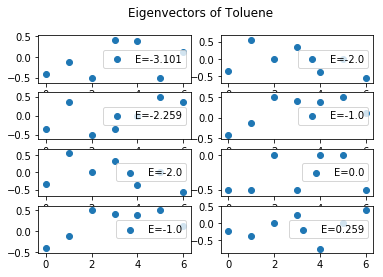

In [32]:
pltEigen(tolEigen, 'Toluene')

In [33]:
bondOrder(tol_diagram, tolEigen, [[0,1],[1,2],[2,3],[3,4],[4,5],[5,0],[5,6]])

array([0.5137722 , 0.70459356, 1.15042341, 1.20624249, 0.81101776,
       0.84957659, 1.29540644])

#### Naphthalene

The ASE database does not contain data for naphthalene. Therefore, the Huckel matrix was built manually, and then the steps above were performed on it.

In [34]:
naph = [[0, 1,0, 0, 0, 1, 0, 0, 0, 0],[1, 0, 1, 0, 0, 0, 0, 0, 0, 0],[0, 1, 0, 1, 0, 0, 1, 0, 0, 0],[0,0, 1, 0, 1, 0, 0, 0, 0, 1],[0, 0, 0, 1, 0, 1, 0, 0, 0, 0,],
          [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0, 0, 1, 0, 0],[0, 0, 0, 0, 0, 0, 1, 0, 1, 0],[0, 0, 0, 0, 0, 0, 0, 1, 0, 1],[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]]

naph_H = getHamil(-1,-1, naph)
naphEigen = sortEigen(naph_H)

print(*naphEigen, sep="\n")

[-3.3027756377319935, array([-0.23070093, -0.23070093, -0.4253254 , -0.17352352, -0.40824829,
        0.26286556, -0.4253254 , -0.26286556,  0.40824829, -0.17352352])]
[-2.618033988749893, array([-4.61401867e-01, -4.61401867e-01,  5.30248843e-16, -3.47047043e-01,
        4.08248290e-01,  2.63031476e-16,  2.99361316e-16,  2.47254364e-16,
       -4.08248290e-01, -3.47047043e-01])]
[-2.3027756377319957, array([-4.61401867e-01,  4.61401867e-01,  1.67031125e-15,  3.47047043e-01,
        4.08248290e-01,  4.05048982e-16,  6.36290736e-17, -1.09077602e-16,
        4.08248290e-01, -3.47047043e-01])]
[-2.000000000000001, array([-3.00551556e-01, -3.00551556e-01, -2.62865556e-01,  3.99585738e-01,
       -7.27068190e-16, -4.25325404e-01, -2.62865556e-01,  4.25325404e-01,
       -9.13119263e-17,  3.99585738e-01])]
[-1.6180339887498938, array([-0.23070093,  0.23070093, -0.4253254 ,  0.17352352, -0.40824829,
       -0.26286556,  0.4253254 , -0.26286556, -0.40824829, -0.17352352])]
[-0.3819660112501049,

In [35]:
naph_diagram = energyLevelDiagram(naphEigen, 10)
print(naph_diagram)

[[-3.30277564e+00  1.00000000e+00  1.00000000e+00]
 [-2.61803399e+00  1.00000000e+00  1.00000000e+00]
 [-2.30277564e+00  1.00000000e+00  1.00000000e+00]
 [-2.00000000e+00  1.00000000e+00  1.00000000e+00]
 [-1.61803399e+00  1.00000000e+00  1.00000000e+00]
 [-3.81966011e-01  0.00000000e+00  0.00000000e+00]
 [ 1.44486092e-16  0.00000000e+00  0.00000000e+00]
 [ 3.02775638e-01  0.00000000e+00  0.00000000e+00]
 [ 6.18033989e-01  0.00000000e+00  0.00000000e+00]
 [ 1.30277564e+00  0.00000000e+00  0.00000000e+00]]


In [36]:
naph_dE = delocEnergy(naph_diagram)
print(naph_dE)

-3.683238505927555


In [37]:
naph_chargeDen = chargeDensity(naph_diagram, naphEigen)
print(naph_chargeDen)

[1.24512089 1.24512089 0.8618034  0.92154578 1.33333333 0.6381966
 0.8618034  0.6381966  1.33333333 0.92154578]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [-0.23070093 -0.23070093 -0.4253254  -0.17352352 -0.40824829  0.26286556
 -0.4253254  -0.26286556  0.40824829 -0.17352352]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [-4.61401867e-01  4.61401867e-01  1.67031125e-15  3.47047043e-01
  4.08248290e-01  4.05048982e-16  6.36290736e-17 -1.09077602e-16
  4.08248290e-01 -3.47047043e-01]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [-4.61401867e-01 -4.61401867e-01  5.30248843e-16 -3.47047043e-01
  4.08248290e-01  2.63031476e-16  2.99361316e-16  2.47254364e-16
 -4.08248290e-01 -3.47047043e-01]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [-3.00551556e-01 -3.00551556e-01 -2.62865556e-01  3.99585738e-01
 -7.27068190e-16 -4.25325404e-01 -2.62865556e-01  4.25325404e-01
 -9.13119263e-17  3.99585738e-01]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [-4.61401867e-01  4.61401867e-01  1.67031125e-15  3.47047043e-01
  4.08248290e-01  4.05048982e-16  6.36290736e-17 -1.09077602e-16
  4.08248290e-01 -3.47047043e-01]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [-0.23070093  0.23070093 -0.4253254

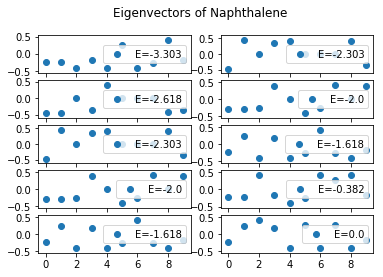

In [38]:
pltEigen(naphEigen, 'Naphthalene')

In [39]:
bondOrder(naph_diagram, naphEigen, [[0,1],[1,2],[2,3],[3,4],[4,5],[5,0],[5,6],[6,7],[7,8],[8,9]])

array([1.18066248, 1.1580093 , 0.78992535, 1.        , 1.        ,
       1.25566442, 0.7763932 , 0.7763932 , 1.        , 1.        ])

### Carbon 60

In [50]:
# gnr = graphene_nanoribbon(4,3,'zigzag', saturated=False) """To produce a graphene nanoribbon 4 unit cells wide and 3 long"""
c60 = molecule('C60')
numC = 60 #number of carbon atoms in the molecule

cutOff = natural_cutoffs(c60)
neighborList = neighborlist.NeighborList(cutOff, self_interaction=False, bothways=True)
neighborList.update(c60)
T = neighborList.get_connectivity_matrix()

H_c60 = getSparseHamil(-1,-1,T)

c60_eigs = getEignVecsSp(H_c60, 60)

#matrix = csr_matrix.todense(matrix) """Not needed when getSparseHamil is used"""

In [51]:
c60_diagram = energyLevelDiagram(c60_eigs, 60)
print(c60_diagram)

[[-4.          1.          1.        ]
 [-3.75659825  1.          1.        ]
 [-3.75659825  1.          1.        ]
 [-3.75659825  1.          1.        ]
 [-3.30277564  1.          1.        ]
 [-3.30277564  1.          1.        ]
 [-3.30277564  1.          1.        ]
 [-3.30277564  1.          1.        ]
 [-3.30277564  1.          1.        ]
 [-2.82024925  1.          1.        ]
 [-2.82024925  1.          1.        ]
 [-2.82024925  1.          1.        ]
 [-2.56155281  1.          1.        ]
 [-2.56155281  1.          1.        ]
 [-2.56155281  1.          1.        ]
 [-2.56155281  1.          1.        ]
 [-2.          1.          1.        ]
 [-2.          1.          1.        ]
 [-2.          1.          1.        ]
 [-2.          1.          1.        ]
 [-2.          1.          1.        ]
 [-2.          1.          1.        ]
 [-2.          1.          1.        ]
 [-2.          1.          1.        ]
 [-2.          1.          1.        ]
 [-1.61803399  1.        

In [52]:
c60_dE = delocEnergy(c60_diagram)
print(c60_dE)

-33.16160379436806


In [53]:
c60_cD = chargeDensity(c60_diagram, c60_eigs)
print(c60_cD)

[1.02600854 0.99203825 1.01907917 0.98143184 0.96986995 0.9528421
 1.04202069 1.03070356 1.00876963 0.98972153 0.98318841 0.95643175
 1.08778739 1.08603358 1.0300085  1.00971514 0.99195975 0.97464514
 0.97628884 1.00855544 1.02030099 1.03070356 0.96986995 1.04813875
 0.97982784 0.96723806 0.96463195 1.01896824 1.04202069 1.00971514
 1.08778739 0.9528421  0.96414861 0.96968645 0.97526726 0.97469265
 1.0300085  1.04813875 1.02030099 1.08603358 1.02600854 0.95643175
 0.98972153 1.01907917 0.96414861 0.98143184 0.99203825 0.97526726
 0.97982784 0.97469265 0.96968645 0.96463195 0.99195975 1.01896824
 0.96723806 0.97628884 1.00876963 1.00855544]


In [56]:
bonds = []
for key in T.keys():
    bonds.append(key)

bondOrder(c60_diagram, c60_eigs, bonds)

array([1.49709715, 1.62492564, 1.47349679, 1.57106999, 1.48240594,
       1.49709715, 1.46959471, 1.4926603 , 1.62492564, 1.45977669,
       1.48868638, 1.57106999, 1.61751597, 1.44697501, 1.45977669,
       1.57821078, 1.45636612, 1.48240594, 1.49134469, 1.51627543,
       1.57821078, 1.47012291, 1.61751597, 1.49134469, 1.45882537,
       1.6285148 , 1.47683129, 1.55647244, 1.52375834, 1.45882537,
       1.45959411, 1.46959471, 1.6285148 , 1.49231031, 1.47349679,
       1.55647244, 1.66879333, 1.45636612, 1.49231031, 1.65998884,
       1.43227772, 1.52375834, 1.41502897, 1.50624575, 1.65998884,
       1.46484056, 1.66879333, 1.41502897, 1.46934816, 1.58678022,
       1.4757386 , 1.57980811, 1.47012291, 1.46934816, 1.47352498,
       1.45959411, 1.58678022, 1.50257847, 1.47683129, 1.57980811,
       1.6359883 , 1.43227772, 1.50257847, 1.61751597, 1.49134469,
       1.47012291, 1.44697501, 1.45977669, 1.61751597, 1.51350452,
       1.6359883 , 1.44697501, 1.48581165, 1.58913466, 1.46495